# Building A ODE solver
We have created a `ChemicalNetwork` with 2 reactions and 1 cooling action. Now we are ready to put together an ODE solver to study the evolution of this chemical network with different initial conditions.

The dynamics of the system is specified by the set of ODE equations.
$$ \frac{d \bf y}{dt} = f(\bf y) $$
where $\bf y$ corresponds to the abundance vector for the species of interest, and $f(\bf y)$ describes the dynamics. $\bf y$ in this case is `[H_1, H_2, de, ge]`.

In the below, we will outline how can `dengo` help you with putting together the RHS function below and building a ODE solver.
$$
    \begin{align*}
    \rm \frac{d H}{dt} &=  \rm k_{02}(T) \,  H^+ \, e^-  - k_{01}(T) \,  H \, e^- \\
    \rm \frac{d  H^+}{dt} &= \rm - k_{02}(T) \,  H^+ \, e^- + k_{01}(T) \,  H \, e^-  \\
    \rm  \frac{d e^-}{dt} &=  \rm - k_{02}(T) \,  H^+ \, e^-  + k_{01}(T) \,  H \, e^- \\
    \rm  \frac{d ge}{dt} &=  \rm - reHII(T) \,  H^+ \, e^- 
    \end{align*}
$$ 

This can be broken down into 3 different steps. 
1. Evalulate temperature from the state vector
2. Evalulate/ Interpolate the reaction rates from the temperature
3. Evalulate the RHS function
4. Feed the RHS function into an ODE solver

## Import Libraries and Create the Network

Primordial rates and cooling for the 9-species network are included in the default dengo library in `dengo.primordial_rates` and `dengo.primordial_cooling`. The reactions and cooling are added automatically to the `reaction_registry`, `cooling_registry` and `species_registry` with the call to `dengo.primordial_rates.setup_primordial`.  Here we setup the same sample network we demonstrated in the last chapter with `k01`, `k02` and `reHII`.


In [1]:
import dengo
from dengo.chemical_network import \
 ChemicalNetwork, \
 reaction_registry, \
 cooling_registry, species_registry
import dengo.primordial_rates
import dengo.primordial_cooling

dengo.primordial_rates.setup_primordial()

simpleNetwork = ChemicalNetwork()
simpleNetwork.add_reaction("k01")
simpleNetwork.add_reaction("k02")
simpleNetwork.add_cooling("reHII")
simpleNetwork.init_temperature((1e0, 1e8))

Adding reaction: k01 : 1*H_1 + 1*de => 1*H_2 + 2*de
Adding reaction: k02 : 1*H_2 + 1*de => 1*H_1


## Evaluate the temperature

The temperature $T$ as we have seen above is critical to the rate at which the reaction proceeds. The temperature can be evaluated from the internal energy term `ge`. 
Internal energy of an ideal gas is:
$$ E = \rho \epsilon = c_V T = \frac{nkT}{\gamma -1}$$
For monoatomic gas $\gamma$ is $5/3$, and diatomic gas $\gamma$ is $7/5$. $\gamma$ refers to the adiabatic constant, and it is directly related to the degree of freedom available to the species $f = \frac{2}{\gamma -1}$. When the temperature is higher, other degrees of freedom might get excited, and which leads toa temperature-dependent $\gamma$.

The total internal energy in the mixture of ideal gas is:
$$\epsilon = \sum_s \frac{n_s kT}{\gamma_s -1}$$.
$T$ can be thus be calculated from $E$ and the abundance of all the avaialble species $n_s$.

In our simple example, the internal energy can be written out plainly as

$$
\begin{align*}
\epsilon &= (\frac{n_{\rm H}}{\gamma - 1}+\frac{n_{\rm H^+}}{\gamma - 1}+\frac{n_{\rm e^-}}{\gamma - 1}) \times \frac{k T}{\rho} \\
&= \Gamma_{\rm eff} \frac{k T}{\rho} \\
T &= \frac{\rho \epsilon}{\Gamma_{\rm eff} k}
\end{align*}
$$

`Dengo` can generate the `sympy` expression of $\Gamma_{\rm eff}$ with the function `ChemicalNetwork.gamma_factor()`. We are at the position to define our our function to calculate the temperature, with the expression provided to us by `Dengo`. Notice that in `Dengo`, the internal energy term $ge$ is treated as energy per unit mass density $\epsilon = E/\rho$. You also ask `Dengo` to directly spit out the expression for temperature with `simpleNetwork.temperature_calculation()`.

In [2]:
simpleNetwork.gamma_factor()

H_1/(gamma - 1.0) + H_2/(gamma - 1.0) + de/(gamma - 1.0)

In [3]:
sorted(simpleNetwork.required_species)

[Species: H_1, Species: H_2, Species: de, Species: ge]

In [4]:
simpleNetwork.print_mass_density()

'1.0079400000000001*H_1 + 1.0079400000000001*H_2'

In [5]:
import numpy.typing as npt

gamma = 5./3.
kb    = 1.38e-16
mh    = 1.67e-24

def calculate_temperature(state: npt.ArrayLike):
    """calculate temperature in (K) based on the state space vector"""

    # extract the abundance from the state vector
    H_1, H_2, de, ge = state
    inv_gammam1 = 1 / (gamma - 1)
    gamma_factor = (H_1 + H_2 + de) * inv_gammam1
    rho = 1.00794*H_1 + 1.00794*H_2
    T = ge / gamma_factor / kb * mh * rho
    return T

## Evaluate the reaction rates
<!-- Reaction rates usually have a temperature dependence. For example, for reactions following the [Arrhenius equation](https://en.wikipedia.org/wiki/Arrhenius_equation) usually have the forms of $$k(T) = A e^{-\frac{E_a}{RT}}$$, where $k$ is the reaction rate, $E_a$ is the activation energy of the reaction, $T$ is the temperature, $A$, $R$ are the pre-exponential factor, and the universal gas constant respectively. $A$ is sometimes dependent further on temperature in [Modified Arrhenius equation](https://en.wikipedia.org/wiki/Arrhenius_equation#Modified_Arrhenius_equation). -->

Evaluating these rates on the fly would be computationally expensive. One possible way of reducing the computational time is to interpolate from a pre-calculated reaction rates table. The rates are specified when the reactions `rxn` are first created with the `@reaction` decorator. They can be evaluated handily with `rxn.coeff_fn(chemicalnetwork)`. The range of temperature of interest for example $T = \rm (1, 10^8) K$ can be first specified with `ChemicalNetwork.init_temperature(T_bounds=(1e0, 1e8), n_bins=1024)`. 

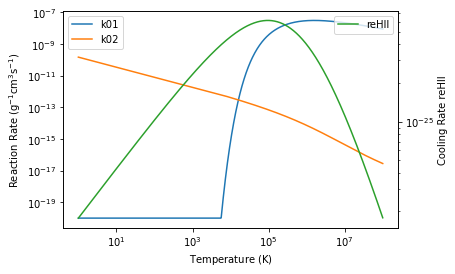

In [6]:
# The reactions in the chemical network can be assessed
import numpy as np
import matplotlib.pyplot as plt
reactions = simpleNetwork.reactions
cooling   = simpleNetwork.cooling_actions

rxnk01 = reactions['k01']
rxnk02 = reactions['k02']
reHII  = cooling['reHII']
temperature = simpleNetwork.T
rxnk01_rate = rxnk01.coeff_fn(simpleNetwork)
rxnk02_rate = rxnk02.coeff_fn(simpleNetwork)

plt.loglog(temperature, rxnk01_rate, label='k01')
plt.loglog(temperature, rxnk02_rate, label='k02')
plt.xlabel(r'Temperature $(\rm K)$')
plt.ylabel(r'Reaction Rate $(\rm g^{-1} cm^{3} s^{-1} )$')
plt.legend()
ax2 = plt.twinx()
coolreHII_rate = reHII.tables['reHII'](simpleNetwork)
ax2.loglog(temperature, coolreHII_rate,color='C2', label='reHII')
plt.ylabel(r'Cooling Rate reHII')
plt.legend()

In [8]:
logT       = np.log10(temperature)
k01lograte = np.log10(rxnk01_rate)
k02lograte = np.log10(rxnk02_rate)
coolreHII_lograte = np.log10(coolreHII_rate)

def interpolate_rates(T: npt.ArrayLike):
    """interpolate the reaction rate in log space
    
    Parameters
    ----------
        T: the temperate at which the rate is evaluated
    
    Return
    ------
        k02: interpolated reaction rate at temperature T 
    """
    k01 = 10**np.interp(np.log10(T), logT, k01lograte)
    k02 = 10**np.interp(np.log10(T), logT, k02lograte)
    return k01, k02

def interpolate_cooling_rates(T: npt.ArrayLike):
    """interpolate the cooling rate in log space
    
    Parameters
    ----------
        T: the temperate at which the rate is evaluated
    
    Return
    ------
        coolreHII_rate: interpolated cooling rate at temperature T 
    """
    coolreHII_rate = 10**np.interp(np.log10(T), logT, coolreHII_lograte)
    return coolreHII_rate

### The RHS function

The dynamics is specified by the set of ODE equations.
$$ \frac{d \bf y}{dt} = f(\bf y) $$
where $\bf y$ corresponds to the abundance vector for the species of interest, and $f(\bf y)$ describes the dynamics.

`Dengo` aggreates the reactions specific to each species $s$ with `ChemicalNetwork.species_total(s)` with `sympy` internally. These sympy expression can be exported to various different code style with `sympy.printing` to `C`, `python` for example.

In [9]:
for s in sorted(simpleNetwork.required_species):
    if s.name != 'ge':
        print(f"d{s.name:>3}dt = {simpleNetwork.species_total(s)}")
    else:
        print(f"d{s.name:>3}dt = {simpleNetwork.print_cooling(assign_to=None)}")

dH_1dt = -k01[i]*H_1*de + k02[i]*H_2*de
dH_2dt = k01[i]*H_1*de - k02[i]*H_2*de
d dedt = k01[i]*H_1*de - k02[i]*H_2*de
d gedt = -reHII_reHII[i]*H_2*de


In [10]:
def rhs_func(state, t):
    """evaluate the dydt given the state y at time t
    
    Parameters
    ----------
        state: np.ndarray
            the number density of different species
        t: float
            time
    Return
    ------
        coolreHII_rate: interpolated cooling rate at temperature T 
    """
    H_1, H_2, de, ge = state
    
    T   = calculate_temperature(state)
    k01, k02 = interpolate_rates    (T)
    rho = 1.00794*H_1 + 1.00794*H_2
    
    reHII_reHII = interpolate_cooling_rates(T)
    
    dH_1dt = k02*H_2*de - k01*H_1*de
    dH_2dt = -k02*H_2*de + k01*H_1*de
    ddedt = -k02*H_2*de + k01*H_1*de
    dgedt = (-reHII_reHII*H_2*de)/ rho /mh
    
    dstatedt = np.array([dH_1dt,dH_2dt,ddedt,dgedt])
    return dstatedt

## Integrate the System
Once the RHS function is specified, we are ready to evolve the system. Here we will use the `scipy.integrate.odeint` to integrate the ODE. The initial value are specified below as a 1D-vector. And the output logarithmically-spaced timesteps are also fed into the ODE solver. 

In [11]:
# Prepare the initial state vector
ge = 1e13  #erg/g
H_1 = 1e-2# 1/cm^3
H_2 = 1e-2# 1/cm^3
de  = 1e-2# 1/cm^3
state = np.array([H_1, H_2, de, ge])

/tmp/ipykernel_1763/3292852106.py:21: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  f.legend(


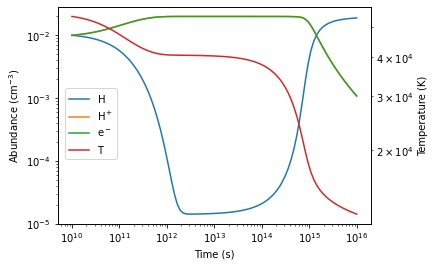

In [12]:
from scipy.integrate import odeint

timesteps = np.logspace(10, 16,101)
output     = odeint(rhs_func, state, t=timesteps)
H_1_traj, H_2_traj, de_traj, ge_traj = output.T

f, ax = plt.subplots()
l1= ax.loglog(timesteps, H_1_traj)
l2= ax.loglog(timesteps, H_2_traj)
l3= ax.loglog(timesteps, de_traj)
ax2 = ax.twinx()
T_traj = calculate_temperature(output.T)
l4= ax2.loglog(timesteps, T_traj, color='C3')


ax.set_ylabel(r"Abundance ($\rm cm^{-3}$)")
ax2.set_ylabel("Temperature (K)")

ax.set_xlabel("Time (s)")

f.legend(
    [l1,l2,l3,l4], 
    labels=[r'$\rm H$',r'$\rm H^+$',r'$\rm e^-$',r'$\rm T$'],
    loc=[0.15,0.4]
)
plt.subplots_adjust(right=0.85)

### Summary
1. We have built a reaction chemical network with 2 reactions and 1 cooling action from scratch with `Dengo`!
2. We demonstrated how can we build a simple ODE solver with the symbolic outputs from `Dengo`!

In the next chapter, we demonstrate how `Dengo` can be used in conjunction with `Jinja2` to write a solver for arbitary network in the next chapter.